In [26]:
import os
import pandas as pd
import matplotlib.pyplot as plt

In [33]:
log_dirs = {
    "compare": "../logs/dql_d4rl_compare/walker2d-medium-replay-v2/lr_0.0003/42",
    "qlearning": "../logs/dql_d4rl/walker2d-medium-replay-v2/lr_0.0003-ql_True/42",
    # "sequence": "../logs/dql_d4rl/walker2d-medium-replay-v2/lr_0.0003/42",
}

In [31]:
def read_metrics(log_dir: str, metric_name: str):
    return pd.read_csv(os.path.join(log_dir, "progress.csv"))[metric_name].values

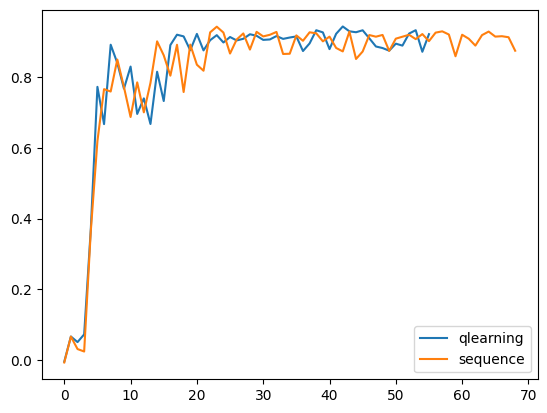

In [13]:
for name, log_dir in log_dirs.items():
    avg_returns = read_metrics(log_dir, "average_normalizd_return")
    plt.plot(avg_returns[::10], label=name)
plt.legend()

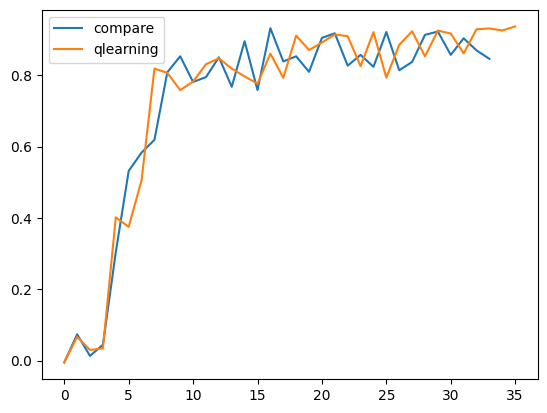

In [34]:
for name, log_dir in log_dirs.items():
    avg_returns = read_metrics(log_dir, "average_normalizd_return")
    plt.plot(avg_returns[::10], label=name)
plt.legend()